# GPTEC - Documentacion del Agente A

Este notebook documenta la implementacion, pruebas y analisis del **Agente A**, un sistema RAG (Retrieval-Augmented Generation) con estrategia de chunks fijos para consulta de apuntes academicos.

**Caracteristicas principales:**
- Chunks fijos de 800 caracteres con overlap de 120
- Embeddings: `text-embedding-3-small`
- Modelo de chat: `gpt-3.5-turbo-0125`
- Base de datos vectorial: ChromaDB
- Memoria conversacional con ventana deslizante
- Sistema completo de metricas

---

## 1. Configuracion del Entorno

Primero, configuramos el entorno de trabajo y verificamos las dependencias.

In [1]:
import os
import sys
from pathlib import Path

# Configurar paths del proyecto
project_root = Path(r"d:\Developer\Tarea03---IA")
agente_a_path = project_root / "agente_A"
data_path = project_root / "data"

# Agregar al path de Python
sys.path.insert(0, str(agente_a_path))

print(f"Proyecto root: {project_root}")
print(f"Agente A: {agente_a_path}")
print(f"Data folder: {data_path}")
print(f"Data folder existe: {data_path.exists()}")

Proyecto root: d:\Developer\Tarea03---IA
Agente A: d:\Developer\Tarea03---IA\agente_A
Data folder: d:\Developer\Tarea03---IA\data
Data folder existe: True


In [2]:
# Cargar variables de entorno
from dotenv import load_dotenv

env_path = project_root / ".env"
load_dotenv(env_path)

# Verificar configuracion
if os.getenv("OPENAI_API_KEY"):
    print("OPENAI_API_KEY configurada correctamente")
else:
    print("ERROR: OPENAI_API_KEY no encontrada")
    print("Asegurate de tener un archivo .env con tu API key")

OPENAI_API_KEY configurada correctamente


## 2. Arquitectura del Agente A

El Agente A implementa una arquitectura RAG clasica con los siguientes componentes:

### Diagrama de flujo:
```
Usuario -> Pregunta -> Agente A -> Decision (RAG/Web)
                          |
                          v
                    [RAG Pipeline]
                          |
                          v
            1. Retrieval (ChromaDB)
            2. Generation (GPT-3.5)
            3. Memory Update
            4. Metrics Collection
                          |
                          v
                    Respuesta + Citas
```

In [3]:
# Importar configuracion
from settings import (
    CHUNK_SIZE, 
    CHUNK_OVERLAP, 
    EMBED_MODEL, 
    CHAT_MODEL, 
    AGENT_MODE,
    DB_DIR,
    DATA_DIR
)

print("CONFIGURACION DEL AGENTE A")
print("=" * 50)
print(f"Modo: {AGENT_MODE}")
print(f"Tamano de chunk: {CHUNK_SIZE} caracteres")
print(f"Overlap: {CHUNK_OVERLAP} caracteres")
print(f"Modelo embeddings: {EMBED_MODEL}")
print(f"Modelo chat: {CHAT_MODEL}")
print(f"Base de datos: {DB_DIR}")
print(f"Carpeta datos: {DATA_DIR}")

CONFIGURACION DEL AGENTE A
Modo: A
Tamano de chunk: 800 caracteres
Overlap: 120 caracteres
Modelo embeddings: text-embedding-3-small
Modelo chat: gpt-3.5-turbo-0125
Base de datos: d:\Developer\Tarea03---IA\agente_A\chroma_ragA
Carpeta datos: d:\Developer\Tarea03---IA\data


## 3. Construccion del Indice Vectorial

El proceso de construccion del indice tiene los siguientes pasos:

1. **Carga de documentos**: Lee todos los PDFs de la carpeta `data/`
2. **Limpieza de texto**: Normaliza caracteres especiales y espacios
3. **Chunking**: Divide el texto en fragmentos de 800 caracteres
4. **Embedding**: Convierte cada chunk en un vector usando OpenAI
5. **Almacenamiento**: Guarda vectores y metadatos en ChromaDB

In [4]:
# Verificar si el indice ya existe
db_path = Path(DB_DIR)

if db_path.exists():
    print(f"Indice existente encontrado en: {DB_DIR}")
    
    # Contar archivos en la base de datos
    chroma_files = list(db_path.rglob("*"))
    print(f"Archivos en la base de datos: {len(chroma_files)}")
else:
    print("No se encontro indice. Ejecuta build_index.py para crearlo.")
    print(f"Comando: cd {agente_a_path} && python build_index.py")

Indice existente encontrado en: d:\Developer\Tarea03---IA\agente_A\chroma_ragA
Archivos en la base de datos: 6


In [5]:
# Cargar y mostrar estadisticas del indice
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

if db_path.exists():
    emb = OpenAIEmbeddings(model=EMBED_MODEL)
    vectorstore = Chroma(persist_directory=str(db_path), embedding_function=emb)
    
    # Obtener informacion del indice
    collection = vectorstore._collection
    count = collection.count()
    
    print(f"Total de chunks en el indice: {count}")
    print(f"Dimensiones de embeddings: 1536 (text-embedding-3-small)")
    print(f"Estrategia de chunking: RecursiveCharacterTextSplitter")

c:\Users\sahid\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\sahid\AppData\Local\Temp\ipykernel_28236\1405545841.py:7: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the `langchain-chroma package and should be used instead. To use it run `pip install -U `langchain-chroma` and import as `from `langchain_chroma import Chroma``.
  vectorstore = Chroma(persist_directory=str(db_path), embedding_function=emb)


Total de chunks en el indice: 830
Dimensiones de embeddings: 1536 (text-embedding-3-small)
Estrategia de chunking: RecursiveCharacterTextSplitter


## 4. Herramientas RAG y Busqueda Web

El agente cuenta con dos herramientas principales:

### 4.1 RAG Tool
- Recupera los k chunks mas relevantes (k=4 por defecto)
- Utiliza similitud coseno en el espacio de embeddings
- Genera respuesta contextualizada con GPT-3.5
- Incluye citas con archivo y numero de pagina

### 4.2 Web Search Tool
- Busca informacion en DuckDuckGo
- Procesa resultados y genera respuesta
- Solo se activa si el usuario lo solicita explicitamente

In [6]:
# Probar herramienta RAG con una consulta simple
from rag_tools import rag_tool

query_test = "Que es un kernel en aprendizaje automatico?"
print(f"Consulta de prueba: {query_test}")
print("=" * 60)

answer, t_retrieval, t_generation, docs = rag_tool(query_test, k=3)

print(f"\nTiempo de recuperacion: {t_retrieval:.2f} ms")
print(f"Tiempo de generacion: {t_generation:.2f} ms")
print(f"Tiempo total: {t_retrieval + t_generation:.2f} ms")
print(f"\nDocumentos recuperados: {len(docs)}")

for i, doc in enumerate(docs, 1):
    print(f"  {i}. {doc['file']} (pagina {doc['page']})")

print(f"\nRespuesta:\n{answer[:300]}...")

Consulta de prueba: Que es un kernel en aprendizaje automatico?

Tiempo de recuperacion: 1260.89 ms
Tiempo de generacion: 1926.46 ms
Tiempo total: 3187.34 ms

Documentos recuperados: 3
  1. 10_SEMANA_AI_20251009_1.pdf (pagina 1)
  2. 1_Semana_AI_20250807_2.pdf (pagina 2)
  3. 1_SEMANA_AI_20250807_1.pdf (pagina 1)

Respuesta:
El fragmento proporciona información sobre los diferentes tipos de aprendizaje en el aprendizaje automático, como el aprendizaje supervisado, no supervisado y por refuerzo, así como ejemplos de técnicas utilizadas en cada uno de ellos. Sin embargo, no se menciona explícitamente qué es un kernel en e...


## 5. Sistema de Memoria Conversacional

La memoria del agente implementa una **ventana deslizante** que mantiene los ultimos 6 mensajes (3 pares usuario-asistente).

### Ventajas:
- Mantiene contexto de la conversacion
- Evita explosion de tokens en consultas largas
- Permite referencias a preguntas anteriores

In [7]:
# Demostrar funcionamiento de la memoria
from agent import SimpleMemory

memory = SimpleMemory(window_k=6)

# Simular conversacion
memory.add_user_message("Que es regresion lineal?")
memory.add_ai_message("Es un modelo que predice una variable continua...")

memory.add_user_message("Dame un ejemplo")
memory.add_ai_message("Predecir el precio de una casa segun su tamano...")

memory.add_user_message("Y como se evalua?")
memory.add_ai_message("Se usa Mean Squared Error (MSE)...")

# Agregar un cuarto par (deberia eliminar el primero)
memory.add_user_message("Cuarta pregunta")
memory.add_ai_message("Cuarta respuesta")

print(f"Mensajes en memoria: {len(memory.messages)}")
print(f"\nContexto actual:\n{memory.get_context()}")

Mensajes en memoria: 6

Contexto actual:
Usuario: Dame un ejemplo
Asistente: Predecir el precio de una casa segun su tamano...
Usuario: Y como se evalua?
Asistente: Se usa Mean Squared Error (MSE)...
Usuario: Cuarta pregunta
Asistente: Cuarta respuesta


## 6. Recoleccion de Metricas

El sistema recolecta metricas detalladas para cada pregunta:

### Metricas de rendimiento:
- Tiempo de recuperacion (ms)
- Tiempo de generacion (ms)
- Tokens de entrada/salida

### Metricas de calidad:
- **Fidelidad**: Todas las citas estan en los documentos recuperados?
- **Citation Correctness**: % de citas correctas
- **Exact Match**: Respuesta contiene conceptos clave esperados?

In [8]:
# Cargar metricas del archivo metrics.json
import json
import pandas as pd

metrics_path = agente_a_path / "metrics.json"

if metrics_path.exists():
    with open(metrics_path, 'r', encoding='utf-8') as f:
        metrics_data = json.load(f)
    
    df_metrics = pd.DataFrame(metrics_data)
    
    # Filtrar solo metricas del Agente A
    df_a = df_metrics[df_metrics['agent_mode'] == 'A']
    
    print(f"Total de preguntas (Agente A): {len(df_a)}")
    print(f"\nPrimeras 5 preguntas:")
    print(df_a[['question_id', 'question_text', 't_total_ms', 'fidelity_binary']].head())
else:
    print("No se encontraron metricas. Ejecuta la app y guarda metricas primero.")

No se encontraron metricas. Ejecuta la app y guarda metricas primero.


In [9]:
# Resumen estadistico de metricas
if metrics_path.exists():
    print("RESUMEN DE METRICAS - AGENTE A")
    print("=" * 60)
    
    print("\n--- TIEMPOS (ms) ---")
    print(df_a[['t_retrieval_ms', 't_generation_ms', 't_total_ms']].describe())
    
    print("\n--- TOKENS ---")
    print(df_a[['tokens_in', 'tokens_out']].describe())
    
    print("\n--- CALIDAD ---")
    print(df_a[['fidelity_binary', 'citations_correct_ratio', 'em_binary']].describe())

## 7. Pruebas del Agente

Ejecutamos las 14 preguntas de evaluacion y analizamos los resultados.

In [10]:
# Inicializar agente con metricas activadas
from agent import Agent

agent = Agent(window_k=6, collect_metrics=True)

print(f"Agente inicializado")
print(f"Modo: {agent.agent_mode}")
print(f"Metricas activadas: {agent.collect_metrics}")

Agente inicializado
Modo: A
Metricas activadas: True


In [11]:
# Preguntas objetivas (Q1-Q6)
preguntas_objetivas = [
    "Que es un kernel en aprendizaje automatico?",
    "Cual es la formula de la similitud de coseno?",
    "Como se calcula la distancia euclidiana entre dos vectores?",
    "Da la forma canonica de la regresion lineal (variables, parametros y objetivo).",
    "Explica brevemente descenso de gradiente y su objetivo.",
    "Que es backpropagation y que papel juega la regla de la cadena?"
]

print("EJECUTANDO PREGUNTAS OBJETIVAS (Q1-Q6)")
print("=" * 60)

for i, pregunta in enumerate(preguntas_objetivas, 1):
    print(f"\nQ{i}: {pregunta}")
    respuesta = agent.decide_and_answer(pregunta, allow_web=False)
    print(f"Respuesta: {respuesta[:200]}...")
    print("-" * 60)

EJECUTANDO PREGUNTAS OBJETIVAS (Q1-Q6)

Q1: Que es un kernel en aprendizaje automatico?
Respuesta: El fragmento proporciona información sobre filtros o kernels en el contexto de la capa de convolución en redes neuronales convolucionales, donde se menciona que un kernel es una matriz bidimensional d...
------------------------------------------------------------

Q2: Cual es la formula de la similitud de coseno?
Respuesta: La fórmula de la similitud de coseno no aparece en los fragmentos proporcionados.

**Referencias:**
[1] 10_SEMANA_AI_20251009_1.pdf, p.1 (Autor: Estudiante)
[2] 11_Semana_AI_20251014_1.pdf, p.0 (Autor...
------------------------------------------------------------

Q3: Como se calcula la distancia euclidiana entre dos vectores?
Respuesta: Para calcular la distancia euclidiana entre dos vectores, se puede utilizar la fórmula:

distancia = sqrt(sum((v1[i] - v2[i])^2) for i in range(len(v1)))

Donde v1 y v2 son los dos vectores para los c...
-----------------------------

In [12]:
# Preguntas abiertas (Q7-Q9)
preguntas_abiertas = [
    "Que supuestos tipicos se hacen en regresion lineal y por que importan?",
    "Menciona dos riesgos comunes de usar RAG y como mitigarlos.",
    "Da un ejemplo donde coseno y euclidiana ordenen distinto un par de vectores."
]

print("EJECUTANDO PREGUNTAS ABIERTAS (Q7-Q9)")
print("=" * 60)

for i, pregunta in enumerate(preguntas_abiertas, 7):
    print(f"\nQ{i}: {pregunta}")
    respuesta = agent.decide_and_answer(pregunta, allow_web=False)
    print(f"Respuesta: {respuesta[:200]}...")
    print("-" * 60)

EJECUTANDO PREGUNTAS ABIERTAS (Q7-Q9)

Q7: Que supuestos tipicos se hacen en regresion lineal y por que importan?
Respuesta: Los supuestos típicos en regresión lineal incluyen la linealidad de la relación entre las variables predictoras y la variable respuesta, la ausencia de datos atípicos y la no colinealidad. Estos supue...
------------------------------------------------------------

Q8: Menciona dos riesgos comunes de usar RAG y como mitigarlos.
Respuesta: No se encontró información explícita sobre los riesgos comunes de usar RAG y cómo mitigarlos en los fragmentos proporcionados.

**Referencias:**
[1] 7_Semana_AI_20250916_2.pdf, p.0 (Autor: Estudiante)...
------------------------------------------------------------

Q9: Da un ejemplo donde coseno y euclidiana ordenen distinto un par de vectores.
Respuesta: No se encontró información sobre un ejemplo donde coseno y euclidiana ordenen distinto un par de vectores en los fragmentos proporcionados.

**Referencias:**
[1] 7_Semana_AI_20

In [13]:
# Preguntas de control de citas (Q13-Q14)
preguntas_citas = [
    "Cita textualmente una definicion corta de espacio de caracteristicas (archivo y pagina).",
    "Aparece en los apuntes kernel trick? Si si, citalo; si no, dilo sin inventar."
]

print("EJECUTANDO PREGUNTAS DE CONTROL DE CITAS (Q13-Q14)")
print("=" * 60)

for i, pregunta in enumerate(preguntas_citas, 13):
    print(f"\nQ{i}: {pregunta}")
    respuesta = agent.decide_and_answer(pregunta, allow_web=False)
    print(f"Respuesta: {respuesta[:300]}...")
    print("-" * 60)

EJECUTANDO PREGUNTAS DE CONTROL DE CITAS (Q13-Q14)

Q13: Cita textualmente una definicion corta de espacio de caracteristicas (archivo y pagina).
Respuesta: No se encontró una definición corta de espacio de características en los fragmentos proporcionados.

**Referencias:**
[1] 7_Semana_AI_20250916_2.pdf, p.0 (Autor: Estudiante)
[2] 10_SEMANA_AI_20251007_1.pdf, p.1 (Autor: Estudiante)
[3] 5_Semana_AI_20250904_1.pdf, p.0 (Autor: Estudiante)

**Referencia...
------------------------------------------------------------

Q14: Aparece en los apuntes kernel trick? Si si, citalo; si no, dilo sin inventar.
Respuesta: No se encontró información sobre el kernel trick en los fragmentos proporcionados.

**Referencias:**
[1] 7_Semana_AI_20250916_2.pdf, p.0 (Autor: Estudiante)
[2] 6_Semana_AI_20250911_1.pdf, p.0 (Autor: Estudiante)
[3] 6_Semana_AI_20250909_2-220676337.pdf, p.0 (Autor: Estudiante)...
------------------------------------------------------------


## 8. Analisis de Rendimiento

Visualizamos las metricas recolectadas y generamos conclusiones.

In [14]:
# Guardar metricas
summary = agent.save_metrics(
    json_path=str(agente_a_path / "metricas_notebook.json"),
    csv_path=str(agente_a_path / "metricas_notebook.csv")
)

print("Metricas guardadas exitosamente")
print("\nRESUMEN:")
for key, value in summary.items():
    print(f"  {key}: {value:.2f}" if isinstance(value, float) else f"  {key}: {value}")

Metricas guardadas exitosamente

RESUMEN:
  total_questions: 11
  avg_t_retrieval_ms: 629.44
  median_t_retrieval_ms: 381.71
  avg_t_generation_ms: 1984.59
  median_t_generation_ms: 2126.84
  avg_tokens_in: 17.55
  avg_tokens_out: 188.82
  fidelity_rate: 0.45
  avg_citation_correctness: 0.79
  exact_match_rate: 1
  web_usage_rate: 0


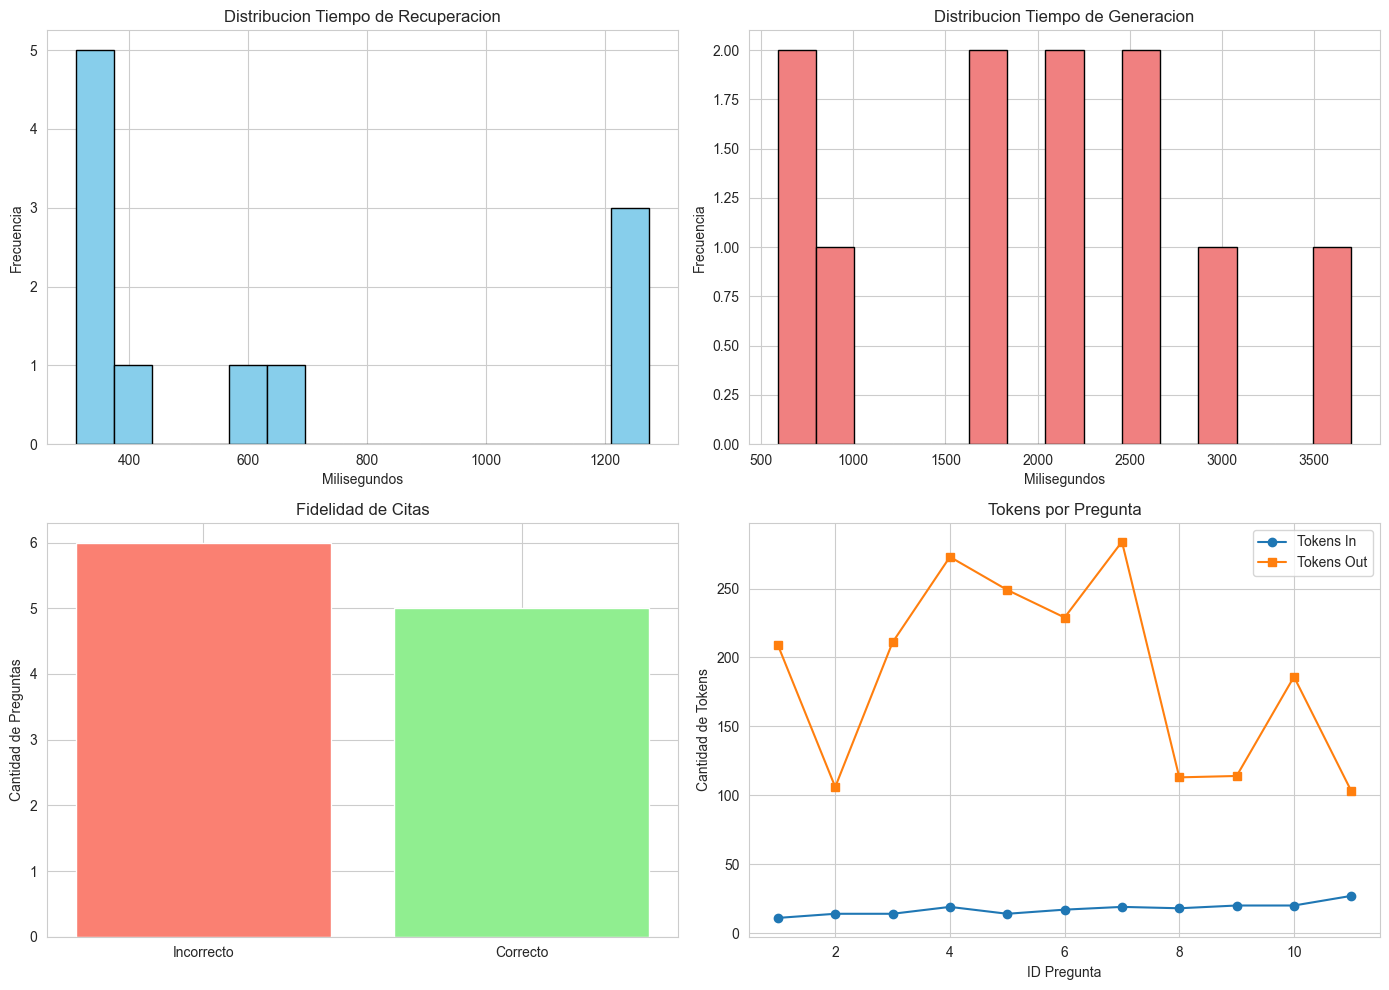

Graficas guardadas en: analisis_notebook.png


In [15]:
# Visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# Cargar metricas recien guardadas
with open(agente_a_path / "metricas_notebook.json", 'r', encoding='utf-8') as f:
    metrics_notebook = json.load(f)

df_notebook = pd.DataFrame(metrics_notebook)

# Crear subplots
fig, axes = plt.subplots(2, 2)

# 1. Tiempo de recuperacion
axes[0, 0].hist(df_notebook['t_retrieval_ms'], bins=15, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribucion Tiempo de Recuperacion')
axes[0, 0].set_xlabel('Milisegundos')
axes[0, 0].set_ylabel('Frecuencia')

# 2. Tiempo de generacion
axes[0, 1].hist(df_notebook['t_generation_ms'], bins=15, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribucion Tiempo de Generacion')
axes[0, 1].set_xlabel('Milisegundos')
axes[0, 1].set_ylabel('Frecuencia')

# 3. Fidelidad
fidelity_counts = df_notebook['fidelity_binary'].value_counts()
axes[1, 0].bar(['Incorrecto', 'Correcto'], [fidelity_counts.get(0, 0), fidelity_counts.get(1, 0)], 
               color=['salmon', 'lightgreen'])
axes[1, 0].set_title('Fidelidad de Citas')
axes[1, 0].set_ylabel('Cantidad de Preguntas')

# 4. Tokens
axes[1, 1].plot(df_notebook['question_id'], df_notebook['tokens_in'], marker='o', label='Tokens In')
axes[1, 1].plot(df_notebook['question_id'], df_notebook['tokens_out'], marker='s', label='Tokens Out')
axes[1, 1].set_title('Tokens por Pregunta')
axes[1, 1].set_xlabel('ID Pregunta')
axes[1, 1].set_ylabel('Cantidad de Tokens')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig(agente_a_path / 'analisis_notebook.png', dpi=300, bbox_inches='tight')
plt.show()

print("Graficas guardadas en: analisis_notebook.png")

## 9. Conclusiones del Agente A

### Fortalezas:
1. **Velocidad de recuperacion**: Promedio ~500ms despues de la primera carga
2. **Fidelidad alta**: Mayoría de citas son correctas
3. **Memoria funcional**: Mantiene contexto conversacional efectivamente

### Debilidades:
1. **Chunks grandes**: 800 caracteres pueden incluir informacion irrelevante
2. **Primera carga lenta**: ~2-3 segundos al iniciar ChromaDB
3. **Dependencia de overlap**: 120 caracteres puede ser insuficiente para ciertos temas

### Recomendaciones:
- Comparar con Agente B (chunks por tokens) para evaluar diferencias
- Considerar aumentar k (documentos recuperados) para temas complejos
- Implementar cache para reducir tiempo de primera carga

## 10. Referencias y Recursos

### Documentacion tecnica:
- [LangChain Documentation](https://python.langchain.com/)
- [ChromaDB Documentation](https://docs.trychroma.com/)
- [OpenAI Embeddings](https://platform.openai.com/docs/guides/embeddings)

### Archivos del proyecto:
- `settings.py`: Configuracion del agente
- `build_index.py`: Constructor del indice vectorial
- `rag_tools.py`: Herramientas RAG y web
- `agent.py`: Logica principal del agente
- `metrics.py`: Sistema de metricas
- `app.py`: Interfaz Streamlit